# Quantum machine learning based image classifier 
## Team #20, 2022, hackathon

We designed the image classifier using quantum machine learning.
An input/target data were obtained from fashion-MNIST.
The data with label 0(T-shirt/top) and 1(Trouser) was only used for this code.

Pytorch/qiskit packages are required for running this code.

Reference: qiskit tutorials (https://qiskit.org/documentation/machine-learning/tutorials/05_torch_connector.html)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

### Check/Choose the device (CPU/GPU)

In [2]:
# checking that cuda is available or not
USE_CUDA=torch.cuda.is_available()
DEVICE=torch.device("cuda" if USE_CUDA else "cpu")
#DEVICE=torch.device("cpu")
print("CUDA: {}".format(USE_CUDA))

CUDA: False


### Declare quantum simulator/quantum computer (local computer, IBM quantum computer, or IBM simulator)

In [3]:
#### IBM quantum computer ####
#IBMQ.save_account('--token--', overwrite = True)
#IBMQ.load_account()
#provider = IBMQ.get_provider(hub='ibm-q-education', group='ibm-3', project='korea-hackathon-')
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
#qasm_sim = provider.backend.ibmq_manila
#statevec_sim = provider.backend.simulator_statevector

#qi = QuantumInstance(qasm_sim)

#### local computer using Aer package ####
qi = QuantumInstance(Aer.get_backend("aer_simulator_statevector"))

### Data acquistion from fashion-MNIST

In [4]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# Download and load the training data
trainset = datasets.FashionMNIST('./F_MNIST_data/', download=True, train=True, transform=transform)
# Download and load the test data
testset = datasets.FashionMNIST('./F_MNIST_data/', download=True, train=False, transform=transform)

In [5]:
### define sampler (extract only data with label 0[T-shirt/top] and 1[trouser])
class Sampler_for_MNIST(torch.utils.data.sampler.Sampler):
    def __init__(self, mask, data_source):
        self.mask = mask
        self.data_source = data_source

    def __iter__(self):
        return iter([i.item() for i in torch.nonzero(self.mask)])

    def __len__(self):
        return len(self.data_source)
    
mask_train = [1 if (trainset[i][1] == 0) | (trainset[i][1] == 1) else 0 for i in range(len(trainset))]
mask_train = torch.tensor(mask_train)

mask_test = [1 if (testset[i][1] == 0) | (testset[i][1] == 1) else 0 for i in range(len(testset))]
mask_test = torch.tensor(mask_test)

# extract the data from whole train/test dataset
sampler_train = Sampler_for_MNIST(mask_train,trainset)
sampler_test = Sampler_for_MNIST(mask_test,testset)

# define the data loader
batch_size=4
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, sampler=sampler_train, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, sampler=sampler_test, shuffle=False)

### Define a function to check the image

In [6]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

### Define qnn model

In [7]:
### Define QNN (reference: qiskit tutorial)
# Set seed for random generators
#algorithm_globals.random_seed = 42
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2, reps=2)

### for quantum computer
#qnn = TwoLayerQNN(
#    2, feature_map, ansatz, input_gradients=True, exp_val=PauliExpectation(), quantum_instance=qi #AerPauliExpectation()
#)

### for local simulation
qnn = TwoLayerQNN(
    2, feature_map, ansatz, input_gradients=True, exp_val=AerPauliExpectation(), quantum_instance=qi
)

### Define framework of quantum machine learning based image classifier

In [8]:
class qnn_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc4 = nn.Linear(1, 1) 
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc4(x)
        x = self.sigmoid(x)
        
        return x.view(-1)
    
model = qnn_classifier().to(DEVICE)

### Set parameters for traininig/testing

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 5;
Ntrain_data = 100;
Ntest_data = 20;

### Train/Test the model (local computer/simulator)

In [10]:
train_losses, test_losses, accuracy_list = [], [], []

for e in range(epochs):
    running_loss = 0
    j = 0
    for i, (images, labels) in enumerate(train_loader):        
        
        if  j < Ntrain_data:
            optimizer.zero_grad()

            output = model(images).float()
            loss = criterion(output, labels.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            j = j + 1

    else:
        test_loss = 0
        accuracy = 0

        with torch.no_grad():
            j=0
            accuracy=0
            for i, (images, labels) in enumerate(test_loader):
                
                if  j < Ntest_data:
                    output = model(images).float()
                    test_loss += criterion(output, labels.float())
                    
                    refine_output = torch.round(output)
                    
                    accuracy = accuracy + torch.sum(refine_output-labels==0)
                                     
                    j = j + 1

        train_losses.append(running_loss/Ntrain_data)
        test_losses.append(test_loss/Ntest_data)
        accuracy_list.append(accuracy/(Ntest_data*batch_size))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/Ntrain_data),
              "Test Loss: {:.3f}.. ".format(test_loss/Ntest_data),
              "Accuracy: {:.3f}".format(accuracy/(Ntest_data*batch_size)))

Epoch: 1/5..  Training Loss: 0.233..  Test Loss: 0.189..  Accuracy: 0.825
Epoch: 2/5..  Training Loss: 0.207..  Test Loss: 0.216..  Accuracy: 0.775
Epoch: 3/5..  Training Loss: 0.171..  Test Loss: 0.151..  Accuracy: 0.863
Epoch: 4/5..  Training Loss: 0.126..  Test Loss: 0.099..  Accuracy: 0.962
Epoch: 5/5..  Training Loss: 0.098..  Test Loss: 0.060..  Accuracy: 0.975


### Train using qiskit runtime package (only for IBM quantum computer)

In [ ]:
torch_runtime_client = TorchRuntimeClient(
    provider=provider,
    model=model,
    optimizer=optimizer,
    loss_func=criterion,
    epochs=epochs,
    backend=qasm_sim,
)

fit_result = torch_runtime_client.fit(train_loader=train_generator, val_loader=test_generator)

### Test the trained model

ground truth: 1
prediction  : 1


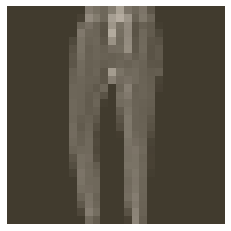

In [14]:
# result 
test_N_image=10

#sample_list=np.where(testset.test_labels==0)  # testset_list for label 0 (T-shirt/top)
sample_list=np.where(testset.test_labels==1) # testset_list for label 1 (trouser)
image=testset[sample_list[0][test_N_image]][0]
label=testset[sample_list[0][test_N_image]][1]
output = model(image.view(-1,1,28,28))

imshow(image);

print('ground truth: {}'.format(label))
print('prediction  : {}'.format(torch.round(output)[0].int()))

### Plot the loss

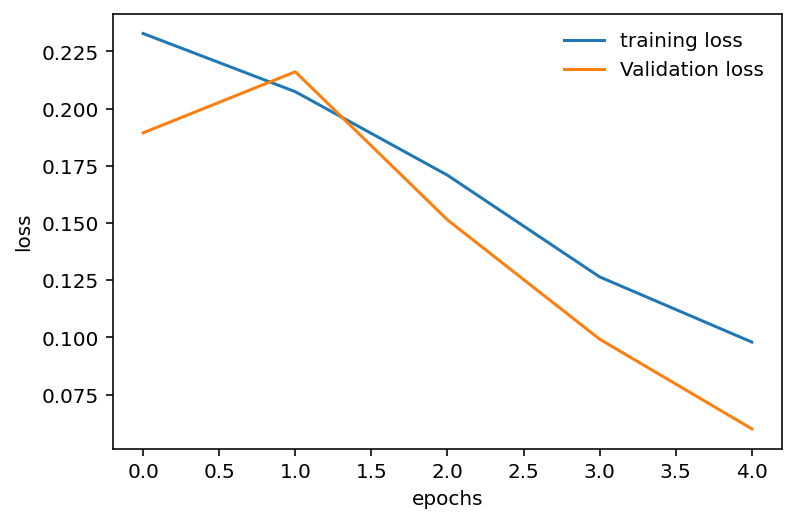

In [15]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(frameon=False)

### Plot the accuracy

Text(0.5, 0, 'epochs')

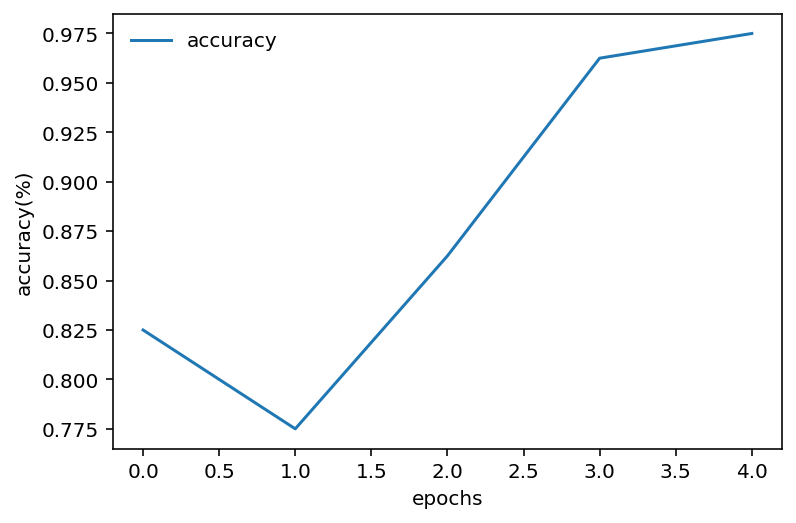

In [16]:
plt.plot(accuracy_list, label='accuracy')
plt.legend(frameon=False)
plt.ylabel('accuracy(%)')
plt.xlabel('epochs')